# Chapter 3: Keras and Data Retrieval in TensorFlow 2

<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/manning_tf2_in_action/blob/master/Ch03-Keras-and-Data-Retrieval/3.1.Keras_APIs.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

## Library imports and some setup

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import random
from sklearn.decomposition import PCA

from tensorflow.keras import layers

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import requests

# Fixing the seed to obtain consistent random values during multiple runs

from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

import tensorflow.keras.backend as K

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

    
def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

# Fixing the random seed
fix_random_seed(4321)
print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.0


## Keras Model Building APIs

### Understanding the data

This is a famous dataset known as the *iris* dataset. The dataset records the petal width/length and sepal width/length for three different kinds of iris flowers.

* Iris-setosa
* Iris-versicolor
* Iris-virginica

The goal is to train a model that, given the petal width/length and sepal width/length, predicts the correct species of flower.

In [2]:
# Section 3.1

import requests
import pandas as pd
import tensorflow as tf

# Retrieve the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
r = requests.get(url)

with open('iris.data', 'wb') as f:
  f.write(r.content)

# Read the data in
iris_df = pd.read_csv('iris.data', header=None)

# Set the column names
iris_df.columns = ['sepal_length', 'sepal_width', 'petal_width', 'petal_length', 'label']
print(iris_df.label.unique())

# Convert labels to integers
iris_df["label"] = iris_df["label"].map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})

# Shuffle the data
iris_df = iris_df.sample(frac=1.0, random_state=4321)

# Normalize the features by subtracting the mean
x = iris_df[["sepal_length", "sepal_width", "petal_width", "petal_length"]]
x = x - x.mean(axis=0)

# Converting integer labels to one-hot vectors
y = tf.one_hot(iris_df["label"], depth=3)

iris_df.head()

['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


,sepal_length,sepal_width,petal_width,petal_length,label
31,5.4,3.4,1.5,0.4,0
23,5.1,3.3,1.7,0.5,0
70,5.9,3.2,4.8,1.8,1
100,6.3,3.3,6.0,2.5,2
44,5.1,3.8,1.9,0.4,0


In [ ]:
print(x)


In [ ]:
print(y)

### Sequential API

The Sequential API is the easiest to use. It can be used to define a simple model that has one input, one output and a sequence of intermediate layers in the middle.

Here we are defining a model with following layers.

* A `Dense` layer with 32 nodes and relu activation
* A `Dense` layer with 16 nodes and relu activation
* A `Dense` layer with 3 nodes and softmax activation

Finally we train the model using a batch size of 64 and for 10 epochs.

In [ ]:
print(len(x))

In [3]:
# Section 3.1
# Code listing 3.1

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

K.clear_session() # Making sure we are clearing out the TensorFlow graph

# Defining Model A with the Sequential API
model = Sequential([
    Dense(32, activation='relu', input_shape=(4,)),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')
])

# Print out a summary of the model
model.summary() 

# Compiling the model with a loss function, an optimizer and a performance metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

print(len(x))
# Fitting the model with data
model.fit(x, y, batch_size=64, epochs=25)

#(4+1) * 32 = 160
#(32+1) * 16 = 528
#(16+1) * 3 = 51

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 3)                 51        
                                                                 
Total params: 739
Trainable params: 739
Non-trainable params: 0
_________________________________________________________________
150
Epoch 1/25
3/3 [==============================] - 1s 3ms/step - loss: 1.1774 - acc: 0.2600
Epoch 2/25
3/3 [==============================] - 0s 3ms/step - loss: 1.1392 - acc: 0.3000
Epoch 3/25
3/3 [==============================] - 0s 4ms/step - loss: 1.1060 - acc: 0.3333
Epoch 4/25
3/3 [=============================

### Functional API

Next, the functional API lets you build more complex models. It lets you build models with parallel inputs, outputs and layers. Here, we will be using the Functional API to build a model that has two parallel `Dense` layers, a single `Dense` layer and an output `Dense` layer.

We will be using two sets of inputs for this model.

* The original inputs
* PCA features (i.e. 2 pricipal components) of the original inputs

#### Building the model

Here we build the model. The model has

* Two parallel input layers
* Two parallel hidden layers
* A layer that concatenates two outputs
* A dense layer consuming the concatenated output
* Final output layer 

In [4]:
# Section 3.1
# Code listing 3.2

from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

K.clear_session() # Making sure we are clearing out the TensorFlow graph

# The two input layers
inp1 = Input(shape=(4,))
inp2 = Input(shape=(2,))

# Two parallel dense layers
out1 = Dense(16, activation='relu')(inp1)
out2 = Dense(16, activation='relu')(inp2)

# Concatenate the two outputs from the parallel layers
out = Concatenate(axis=1)([out1,out2])

# The single dense layer
out = Dense(16, activation='relu')(out)

# The final output layer
out = Dense(3, activation='softmax')(out)

# Create and compile the model
model = Model(inputs=[inp1, inp2], outputs=out)

# Compiling the model with a loss function, an optimizer and a performance metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 16)           80          ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 16)           48          ['input_2[0][0]']                
                                                                                              

#### Compute the PCA features

Here we compute the PCA features using the original data. We will only get the first two principal components.

In [ ]:
# Section 3.1

from sklearn.decomposition import PCA
# Defining a PCA transformer
pca_model = PCA(n_components=2, random_state=4321)
# Generating the PCA features from data
x_pca = pca_model.fit_transform(x)

#### Training the model

The model is trained using a batch size of 64 and for 10 epochs.

In [ ]:
# Section 3.1

# Fitting the model with data
model.fit([x, x_pca], y, batch_size=64, epochs=25)

#### Plotting the network

We can plot a network graph of the model we have built as follows.

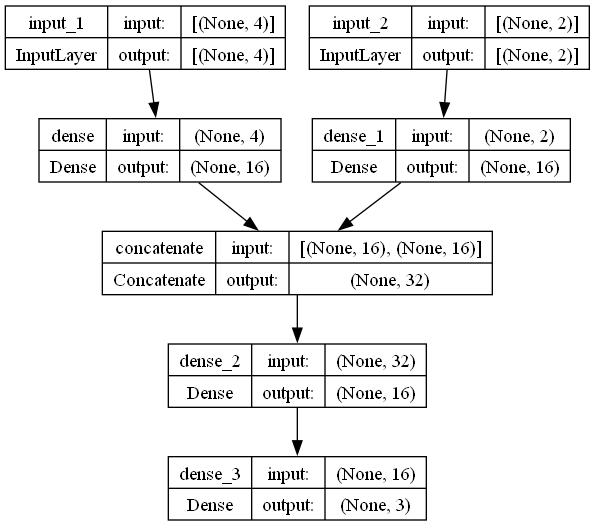

In [5]:
# Section 3.1
import tensorflow as tf
import pydot

tf.keras.utils.plot_model(model, show_shapes=True)

### Sub-classing API

The sub-classing API is considered the hardest to wield, as it requires creating a Python class for the layer or model you want to sub-class. But the added benefit is that you can implement custom computations as sub-classed objects and reuse them in a very convenient manner to create complex models.

In this exercise, we are creating a custom version of the `Dense` layer which has a multiplicative bias in addition to the additive bias. In other words, we will be implementing a new layer called `MulBiasDense` which does the following computation.

$h = \text{Activation}(xW + b \times b_{mul})$

#### Defining the custom layer

Here we define the new custom layer. This layer has three parameters (i.e. `w`, `b` and `b_mul`). When defining the new layer we need to define three important functions.

* `__init__`
* `build`
* `call`

In [6]:
# Section 3.1
# Code listing 3.3

from tensorflow.keras import layers

class MulBiasDense(layers.Layer):
    """ The layer with the new multiplicative bias we want to test """
    
    def __init__(self, units=32, activation=None):
        """ Defines various hyperparameters of the layer"""
        
        super(MulBiasDense, self).__init__()
        self.units = units
        self.activation = activation
    
    def build(self, input_shape):
        """ Defines the parameters (weights and biases)"""
        
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b_mul = self.add_weight(shape=(self.units,),
                                     initializer='glorot_uniform',
                                     trainable=True)

    def call(self, inputs):
        """ Defines the computations that happen in the layer"""
        
        out = (tf.matmul(inputs, self.w) + self.b) * self.b_mul
        return layers.Activation(self.activation)(out)
        


#### Defining the model

Here we define the model using the `MulBiasDense` layer we just created.

In [7]:
# Seciton 3.1
# Code listing 3.4

from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf

K.clear_session() # Making sure we are clearing out the TensorFlow graph

# The input layer
inp = Input(shape=(4,))

# Using the newly defined MulBiasDense layer to create two layers
out = MulBiasDense(units=32, activation='relu')(inp)
out = MulBiasDense(units=16, activation='relu')(out)

# The softmax layer
out = Dense(3, activation='softmax')(out)

model = Model(inputs=inp, outputs=out)
# Compiling the model with a loss function, an optimizer and a performance metric
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 mul_bias_dense (MulBiasDens  (None, 32)               192       
 e)                                                              
                                                                 
 mul_bias_dense_1 (MulBiasDe  (None, 16)               544       
 nse)                                                            
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 787
Trainable params: 787
Non-trainable params: 0
_________________________________________________________________


#### Training the model

We are training the model using a batch size of 64 for 10 epochs.

In [8]:
# Section 3.1
# Fitting the model with data
model.fit(x, y, batch_size=64, epochs=25)

Epoch 1/25
3/3 [==============================] - 0s 0s/step - loss: 1.0982 - acc: 0.6667
Epoch 2/25
3/3 [==============================] - 0s 17ms/step - loss: 1.0971 - acc: 0.6667
Epoch 3/25
3/3 [==============================] - 0s 4ms/step - loss: 1.0962 - acc: 0.6667
Epoch 4/25
3/3 [==============================] - 0s 2ms/step - loss: 1.0953 - acc: 0.6667
Epoch 5/25
3/3 [==============================] - 0s 7ms/step - loss: 1.0944 - acc: 0.6667
Epoch 6/25
3/3 [==============================] - 0s 0s/step - loss: 1.0935 - acc: 0.6667
Epoch 7/25
3/3 [==============================] - 0s 2ms/step - loss: 1.0926 - acc: 0.6667
Epoch 8/25
3/3 [==============================] - 0s 3ms/step - loss: 1.0916 - acc: 0.6667
Epoch 9/25
3/3 [==============================] - 0s 0s/step - loss: 1.0906 - acc: 0.6667
Epoch 10/25
3/3 [==============================] - 0s 4ms/step - loss: 1.0894 - acc: 0.6667
Epoch 11/25
3/3 [==============================] - 0s 4ms/step - loss: 1.0881 - acc: 0.6667